# Setting up drive to access the dataset


*   The dataset is loaded from Gdrive
*   Directories : input_image, label_image, validation_image, validation_label
*   input_image & validation_image contains images in RGB format directly clicked from camera.
*   label directories contain manually binarized images that have been denoised, deskewed, segemented with white background & appropriate thresholding algorithm based on the nature of I/P is applied.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Executed")

Mounted at /content/drive
Executed


In [ ]:
! cp '/content/drive/My Drive/largerDataset.zip' ./
! unzip largerDataset.zip
print("Executed")

In [ ]:
! ls largerDataset
print("Executed")

final_test_images   train_output_images      validation_output_images
train_input_images  validation_input_images
Executed


Constants path variables

In [ ]:
input_image = "/content/largerDataset/train_input_images"
label_image = "/content/largerDataset/train_output_images"
valid_image = "/content/largerDataset/validation_input_images"
valid_label = "/content/largerDataset/validation_output_images"
print("Executed")

Executed


# Basic Imports

In [ ]:
! pip install -q git+https://github.com/tensorflow/examples.git
! pip install -q -U tfds-nightly

In [ ]:
# File handling imports
import os
from os.path import isfile, join
from os import listdir

# Image augmentation & handling imports
import cv2
import skimage.io as io
import skimage.transform as trans
import math
from PIL import Image
import imutils
import random
from skimage.util import img_as_float
from sklearn.model_selection import GridSearchCV

# Tensorflow tensor handling imports
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras import backend as keras
from keras.utils import Sequence
from keras.layers import LeakyReLU,Conv2DTranspose
from keras.preprocessing.image import load_img               
from keras.preprocessing.image import img_to_array  

# Results visualization imports
from IPython.display import clear_output
from matplotlib import cm
import matplotlib.pyplot as plt

print("Executed")

Executed


# Noise handling functions

In [ ]:
# List for randomly accessing noise & blurs
available_noises = ["gauss", "random", "s&p", "poisson", "speckle"]
available_blurs  = ["vertical motion blur", "horizontal motion blur", "average blur", "gauss blur", "median blur", "bilateral blur"]

In [ ]:
class Noise():

    def find_biggest_contour(self,image):
        '''
        Function to find the boundary of the image i.e. the biggest contour, helps us to create a white background after applying
        rotation transform on the image

        args:
            image : (numpy matrix) binarized image
        out :
            mask highlighting the boundary
        '''

        # Copy to prevent modification
        image = image.copy()
        contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        # If no contours are found then we return simply return nothing
        if(len(contours)==0):
            return -1,-1,-1

        # Isolate largest contour
        contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

        # Empty image mask with black background
        mask = np.zeros(image.shape, np.uint8)
        # Applying the largest contour on the empty image of zeros
        cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
        return mask

    def add_noise(self,noise_typ,image):

        '''
        Noise Operations ---------------------------------------------------------
            image       :  The matrix on which operations will be performed
            noise_typ   :  The specific operation to perform
        '''
        noisy_img = []
        # Additive Noise
        if noise_typ == "gauss": 
            row,col,ch= image.shape # H, W, C
            mean = 0

            val = np.random.randint(1,8)
            var = val*(10**-3)  #[0.001 - 0.007]

            sigma = var**0.5
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy_img = image + gauss
    
        # Random Noise
        elif noise_typ == "random":

            row,col,ch = image.shape # H, W, C

            # range from 0,0.2 configurable parameter for the noise
            val = (np.random.randint(10,26))*10**-2
            uniform    = np.random.uniform(0,val,(row,col,ch))
            uniform    = uniform.reshape(row,col,ch)
            noisy_img  = image + uniform

        # Ceil & floor on pixels
        elif noise_typ == "s&p":

            row,col,ch = image.shape
            s_vs_p = 0.5          # % of pixels to perform salt effect

            val = np.random.randint(10,40)
            amount = val*10**-3       #  1 to 4 % of pixels to effect
            noisy_img = np.copy(image)

            # Salt mode 
            num_salt = np.ceil(amount * row*col * s_vs_p)
            coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
            noisy_img[tuple(coords)] = 1

            # Pepper mode
            num_pepper = np.ceil(amount* row*col * (1. - s_vs_p))
            coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
            noisy_img[tuple(coords)] = 0
        
        # Multiplicative Noise
        elif noise_typ == "poisson":
            vals = len(np.unique(image))
            vals = 2 ** np.ceil(np.log2(vals))
            noisy_img = np.random.poisson(image * vals) / float(vals)

        # Multiplicative Noise
        elif noise_typ =="speckle":
            row,col,ch = image.shape
            gauss = np.random.randn(row*col*ch)

            # Control speckle noise across image
            val = np.random.randint(85,97)*10**-2
            indices = np.random.choice(np.arange(gauss.size), replace=False, size=int(gauss.size * val))
            gauss[indices] = 0

            gauss = gauss.reshape(row,col,ch)        
            noisy_img = image + image * gauss
            noisy_img[noisy_img < 0] = 0
            noisy_img[noisy_img > 1] = 1
        
        # To convert to skimage type
        image = img_as_float(noisy_img)      
        return image
    
    def add_blur(self,blur_typ,image):
        
        '''
        # Blur Operations ---------------------------------------------------------
            image       :  The matrix on which operations will be performed
            blur_typ    :  The specific blur operation to perform
        '''

        if blur_typ=="vertical motion blur":
            
            kernel_size = 5
            kernel_v = np.zeros((kernel_size, kernel_size)) 
            kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
            kernel_v /= kernel_size 
            noisy_img = cv2.filter2D(image, -1, kernel_v) 
        
        elif blur_typ=="horizontal motion blur":

            kernel_size = 5
            kernel_h = np.zeros((kernel_size, kernel_size)) 
            kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
            kernel_h /= kernel_size 
            noisy_img = cv2.filter2D(image, -1, kernel_h) 
        
        elif blur_typ=="average blur":
            noisy_img = cv2.blur(image,(5,5))

        elif blur_typ=="gauss blur":
            noisy_img = cv2.GaussianBlur(image,(5,5),0)

        elif blur_typ=="median blur":
            tmp = np.float32(image)
            noisy_img = cv2.medianBlur(tmp,5)
        
        elif blur_typ=="bilateral blur":
            tmp = np.float32(image)
            noisy_img = cv2.bilateralFilter(tmp,5,75,75)
        
                # To convert to skimage type
        
        # To convert to skimage type
        image = img_as_float(noisy_img)
        return image

    def add_saturation(self,sat_typ,image):
        '''
        # Saturation Operation ----------------------------------------------------
            image       :  The matrix on which operations will be performed
            sat_typ     :  We only have single saturation operation currently
        '''

        if sat_typ =="cont_bright":
            aplha = 1.2
            bias = 0.3
            noisy_img = aplha*image+bias
            
            
        # To convert to skimage type
        image = img_as_float(noisy_img)
        return image

    def add_randomTransformations(self,image):

        '''
        # Transformation Operation ----------------------------------------------------
            image       :  The matrix on which operations will be performed
        '''

        rows,cols,ch  = image.shape
        check = 1
        angle = np.random.randint(5,15)
        v     = np.random.randint(0,2)
        if(v == 1):
            angle *=-1
        image = imutils.rotate_bound(image, angle)
        
        uint_img = (image*255).astype('uint8')
        g        = cv2.cvtColor(uint_img, cv2.COLOR_BGR2GRAY)
    

        m1    = self.find_biggest_contour(g) 
        m2    = cv2.bitwise_not(m1, mask = None)
        bg    = cv2.cvtColor(m2,cv2.COLOR_GRAY2RGB)
        image = image + bg
        
        # To convert to skimage type
        image = img_as_float(image)
        return image
        
        """
        # Width Shift
        if(np.random.randint(0,2)):
            rows,cols,ch  = image.shape
            check = 1
            M = np.float32([[1,0,5],[0,1,0]])
            image = cv2.warpAffine(image,M,(cols,rows))

        # Height Shift
        if(np.random.randint(0,2)):
            rows,cols,ch  = image.shape
            check = 1
            M = np.float32([[1,0,0],[0,1,5]])
            image = cv2.warpAffine(image,M,(cols,rows))

        # Image Scaling
        if(np.random.randint(0,2)):
            rows,cols,ch  = image.shape
            scale_x = random.uniform(0.5,1)
            scale_y = random.uniform(0.5,1)
            image = cv2.resize(image,None,fx = scale_x, fy = scale_y,interpolation=cv2.INTER_CUBIC)
            return image
        
        # Shearing
        if(np.random.randint(0,2)):  
            rows,cols,ch  = image.shape
            M = np.float32([[1, 0, 0], [0.2, 1, 0]])
            M[0,2] = -M[0,1] * cols/2
            M[1,2] = -M[1,0] * rows/2
            image = cv2.warpAffine(image, M, (cols, rows))

        return image
        """
print("Executed")

Executed


# Image loader function :
Loads the images for specified size & control variable for adding random noises per instance

## Keras based manual loading

In [ ]:
def load_photos(inp_dir=None, label_dir=None, input_size=(256,256),max_noise_instance = 5):
    
    '''
    *** Note :
        The input image & label image should have the same name
    ***
    Function to load images from the specified directory
    args : 
        inp_dir    : {string} directory to supply input images
        label_dir  : {string} directory to supply label images
        input_size : (tuple) specified size to load the input & label images | default : (256,256,3)
    out :
        list of input  &  images with key as the image name & value as the image
    '''
    
    # list of images and labels
    images = []
    labels = []
    # Loader loop
    for img_name in listdir(inp_dir):

        # load an image from file
        filename_img   = inp_dir + '/' + img_name
        filename_label = label_dir + '/' + img_name

        try:
            image = load_img(filename_img,   color_mode="grayscale", target_size = input_size)
            label = load_img(filename_label, color_mode="grayscale", target_size = input_size)
            image = img_to_array(image)
            image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
            # Normalize
            image/=255
            label = img_to_array(label)
            label = label.reshape((label.shape[0], label.shape[1], label.shape[2]))
            label/=255

            # currently only adding noises
            noises_to_apply = np.random.randint(0,max_noise_instance)
            for i in range(noises_to_apply):
              tmp = image.copy()
              # Noise toss 
              noise_type = available_noises[np.random.randint(0,len(available_noises))]
              tmp_noisy  = Noise().add_noise(noise_type,tmp)
              # adding the augmented noise
              images.append(tmp_noisy)
              labels.append(label)
            
            # always adding the original image
            images.append(image)
            labels.append(label)
        except:
            print("Error while loading : ",img_name)
            continue

    print("Loaded  "+str(len(images))+" number of images &  "+str(len(labels))+" labels")
    return images,labels
print("Executed")

Executed


###Train-Test split & image statistical check
The image dimensions choosen are 1024 x 320 x 1 because :


1.   This is the average dimension of the total images in the instasolv doubts dataset.
2.   Using grayscale images is computationally efficient as compared to RGB images



In [ ]:
train_img, train_lab = load_photos(input_image,label_image,input_size=(320,1024),max_noise_instance = 5)
test_img, test_lab   = load_photos(valid_image,valid_label,input_size=(320,1024),max_noise_instance = 2) # 1 is for making the number 0
print("Executed")

Loaded  2995 number of images &  2995 labels
Error while loading :  .DS_Store
Loaded  32 number of images &  32 labels
Executed


Sanity Check

In [ ]:
print("Size of training : ",len(train_img))
print("Size of test     : ",len(test_img))
print("Shape of image   :",train_img[0].shape)

Size of training :  2995
Size of test     :  32
Shape of image   : (320, 1024, 1)


Storing all noisy Inputs & labels for this training for offline visualizations



In [ ]:
! rm -rf /content/noisy_train_input
! rm -rf /content/noisy_test_input

! rm -rf  /content/noisy_train_label
! rm -rf  /content/noisy_test_label

print("Executed")

Executed


In [ ]:
! mkdir /content/noisy_train_input
! mkdir /content/noisy_test_input

! mkdir  /content/noisy_train_label
! mkdir  /content/noisy_test_label
! ls
print("Executed")

drive		   noisy_test_input	 noisy_train_input	sample_data
largerDataset	   noisy_test_input.zip  noisy_train_input.zip
largerDataset.zip  noisy_test_label	 noisy_train_label
__MACOSX	   noisy_test_label.zip  noisy_train_label.zip
Executed


Storing noisy Inputs

In [ ]:
ctr = 0
for i in train_img:
  try :
    dpi_im = Image.fromarray(np.uint8(i[:,:,0]*255))
    dpi_im.save("/content/noisy_train_input/"+str(ctr)+".png",dpi=(300,300))
  except:
    print("Error in storing : "+str(ctr)+" image")
  ctr+=1
print("Executed")

Executed


In [ ]:
ctr = 0
for i in test_img:
  try :
    dpi_im = Image.fromarray(np.uint8(i[:,:,0]*255))
    dpi_im.save("/content/noisy_test_input/"+str(ctr)+".png",dpi=(300,300))
  except:
    print("Error in storing : "+str(ctr)+" image")
  ctr+=1
print("Executed")

Executed


Storing corresponding labels

In [ ]:
ctr = 0
for i in train_lab:
  dpi_im = Image.fromarray(np.uint8(i[:,:,0]*255))
  dpi_im.save("/content/noisy_train_label/"+str(ctr)+".png",dpi=(300,300))
  ctr+=1
print("Executed")

Executed


In [ ]:
ctr = 0
for i in test_lab:
  dpi_im = Image.fromarray(np.uint8(i[:,:,0]*255))
  dpi_im.save("/content/noisy_test_label/"+str(ctr)+".png",dpi=(300,300))
  ctr+=1
print("Executed")

Executed


Sanity check of images and labels

In [ ]:
! ls "/content/noisy_train_input/" | wc -l
! ls "/content/noisy_train_label/" | wc -l
print("Executed")

2995
2995
Executed


In [ ]:
! ls "/content/noisy_test_input/" | wc -l
! ls "/content/noisy_test_label/" | wc -l
print("Executed")

32
32
Executed


In [ ]:
! zip -r ./noisy_train_input.zip "/content/noisy_train_input/" 
! zip -r ./noisy_train_label.zip "/content/noisy_train_label/"
print("Executed")

In [ ]:
! zip -r ./noisy_test_input.zip "/content/noisy_test_input/" 
! zip -r ./noisy_test_label.zip "/content/noisy_test_label/"
print("Executed")

## Tensorflow dataset optimised loading ** ignore now
Development Phase



In [ ]:
trainInputImagePaths = [input_image+"/"+str(i) for i in listdir(input_image)]
trainLabelImagePaths = [label_image+"/"+str(i) for i in listdir(label_image)]
validInputImagePaths = [valid_image+"/"+str(i) for i in listdir(valid_image)]
validLabelImagePaths = [valid_label+"/"+str(i) for i in listdir(valid_label)]

path_ds  = tf.data.Dataset.list_files(trainInputImagePaths)
label_ds = tf.data.Dataset.list_files(trainLabelImagePaths)
train_dataSet_paths = tf.data.Dataset.zip((path_ds,label_ds))

path_ds_test  = tf.data.Dataset.list_files(validInputImagePaths)
label_ds_test = tf.data.Dataset.list_files(validLabelImagePaths)
test_dataSet_paths = tf.data.Dataset.zip((path_ds_test,label_ds_test))

In [ ]:
def loadAddNoise(paths,numberOfAugmentations = 2):
  try:
    img = tf.io.read_file(paths[0])
    lab = tf.io.read_file(paths[1])

    img = tf.image.decode_png(img,channels=1)
    lab = tf.image.decode_png(lab,channels=1)

    img = tf.image.resize(img,[320,1024])
    lab = tf.image.resize(lab,[320,1024])

    img/=255.0
    lab/=255.0


    img_list = []
    lab_list = []
    print(numberOfAugmentations)
    for i in range(numberOfAugmentations):
      # Noise toss 
      noise_type = available_noises[np.random.randint(0,len(available_noises))]
      #tmp_noisy  = Noise().add_noise(noise_type,tmp)
      shape = img.shape
      tmp_noisy  = tf.py_function(func=Noise().add_noise, inp=[noise_type, img], Tout=tf.float32)
      tmp_noisy.set_shape(shape)

      img_list.append(tmp_noisy)
      lab_list.append(lab)
    
    img_list.append(img)
    lab_list.append(lab)
  
  except :
    print("Error in loading image ",paths[0])
    print("Error in loading label ",paths[1])
  

  return img_list,lab_list
print("Executed")

Executed


In [ ]:
numberOfAugmentations = 5
train = train_dataSet_paths.map(lambda x,y: loadAddNoise([x,y],numberOfAugmentations),num_parallel_calls=tf.data.experimental.AUTOTUNE)
test  = test_dataSet_paths.map(lambda x,y: loadAddNoise([x,y],0),num_parallel_calls=tf.data.experimental.AUTOTUNE)
print("Executed")

5
0
Executed


In [ ]:
iter(train.take(2))

In [ ]:
tf.executing_eagerly()

True

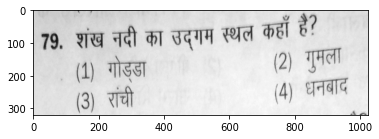

In [ ]:
for image,label in iter(train.take(2)):
  plt.imshow(image[0,:,:,0],cmap="gray")

# Image generator class for efficient model training

>Advantage of using Sequence over generator functions (i.e. yield) :
>
>Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not  the case with generators.



In [ ]:
class DataGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size=1):
        """
        constructor to set up the set
        args :
            x : (list) input images
            y : (list) ouput binarized images
            batch_size : (int) size of the batch for batch gradient descent
        """
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        """
         implict call made by the get item function to return the batch index number
         out :
          returns the batch index number
        """
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        """
        function that generates the batch images for looping
        args:
            idx : index number of batch recieved ftom __len__
        out :
            provides the augmented image and labels
        """
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)
print("Executed")

Executed


# Model Instantiation function


1.   unet() : makes use of a general unet structure & decoder part uses upsample 2d() followed by convolution.
2.   unetTranspose() : same structure as 1 but uses conv2dTranspose to learn joint upsampling & interpolation.
3.   modifiedUnet() : uses encoder function as mobileNetV2 & decoder as the generator used in the upsampiling model pix2pix.

* Leaky Relu with alpha 0.1 provided better performance because of better gradient flow & lack of dead neurons.
* conv2dTranspose generated better binarised images with slighlty blurred edges 
but continuous text.
* modifiedUnet uses pretrained models to see performance gains using transfer learning.
* dice loss is used as a better metric for improved training  because in our case of pixel classification we have unbalanced scenario i.e more white pixels & less black pixels therfore depending purely on pixel wise crossentropy would not be enough.



In [ ]:
def dice_coefficient(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
  return tf.keras.losses.binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
def unet(pretrained_weights = None,input_size = (320,1024,1)):
    '''
    Function used to create an instance of the Unet model 
    args :
        pretrained_weights : (keras h5 file) argument passed when we have already trained weights available.
        input_size         : (tuple) used to specify the dimensions of the input layer of the model.
    out  :
        keras model 
    '''

    inputs = Input(input_size)

    conv1  = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1  = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2  = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3  = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4  = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4  = Dropout(0.5)(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    
    conv6 = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge9)
    
    conv9 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv9) 
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
print("Executed")

Executed


Taking care of the fact that stride is divisble by the filter size to reduce checkerboard effect

In [ ]:
def unetTranspose(alpha = 0.1,pretrained_weights = None,input_size = (320,1024,1)):
    '''
    Function used to create an instance of the Unet model 
    args :
        pretrained_weights : (keras h5 file) argument passed when we have already trained weights available.
        input_size         : (tuple) used to specify the dimensions of the input layer of the model.
    out  :
        keras model 
    '''

    inputs = Input(input_size)

    conv1  = Conv2D(64, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1  = Conv2D(64, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = Conv2D(128, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2  = Conv2D(128, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = Conv2D(256, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3  = Conv2D(256, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = Conv2D(512, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4  = Conv2D(512, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4  = Dropout(0.5)(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    drop5 = Dropout(0.3)(conv5)

    #up6 = Conv2D(512, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = Conv2DTranspose(512,2, strides = (2,2),activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    
    conv6 = Conv2D(512, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv6)

    #up7 = Conv2D(256, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = Conv2DTranspose(256,2, strides = (2,2),activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)

    conv7 = Conv2D(256, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv7)

    #up8 = Conv2D(128, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = Conv2DTranspose(128,2, strides = (2,2),activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)

    conv8 = Conv2D(128, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv8)

    #up9 = Conv2D(64, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = Conv2DTranspose(64,2, strides = (2,2),activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)

    conv9 = Conv2D(64, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = LeakyReLU(alpha=alpha), padding = 'same', kernel_initializer = 'he_normal')(conv9) 
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = 'sgd', loss = loss, metrics = ["accuracy",dice_coefficient])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
print("Executed")

Executed


In [ ]:
def modifiedUnet(input_size=()):

  # Building with mobileNetV2:
  base_model = tf.keras.applications.MobileNetV2(input_shape=[320, 1024, 3], include_top=False)
  
  # Use the activations of these layers
  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
  down_stack.trainable = False
  
  # Upsampling with pix2pix 
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]

  inputs = tf.keras.layers.Input(shape=[320, 1024, 3])
  x      = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(1, 3, strides=2,padding='same')
  x = last(x)

  finalModel = tf.keras.Model(inputs=inputs, outputs=x)
  finalModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  print(finalModel.summary())

  return finalModel

print("Executed")

Executed


In [ ]:
train_generator = DataGenerator(train_img,train_lab,batch_size=1)
valid_generator = DataGenerator(test_img,test_lab,batch_size=1)
modelUnet = unetTranspose(input_size = (320,1024,1)) # 320,1024
print("Executed")

In [ ]:
unet().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 1024, 64 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 1024, 64 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 160, 512, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),)
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

# GRID Search for finding the best hyper-parameters for training ** ignore now

using SKlearn's gridSearchCV to find best value for alpha.
In our case this was not useful because colab instance ran out of memory & the images had to be resized to 256x80 & no cross validation during parameter search. Also the the gridSearchCV only supports vector labels therefore model's output had to be flattened in order to accomodate the search

In [ ]:
param_grid = dict(alpha=[0.1,0.2,0.3,0.4,0.5])
X = ""
y = ""
for i,j in train_generator:
  X = i
  y = j
  break
shapeTuple = y.shape
y = np.reshape(y,(shapeTuple[0],shapeTuple[1]*shapeTuple[2]*shapeTuple[3]))
y.shape

(1, 327680)

Grid Search SkLearn functions

In [ ]:
modelUnet = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=unetTranspose,
                                                           input_size = (80,256,1),
                                                           epochs=10,
                                                           batch_size=1,
                                                           verbose=1)

grid = GridSearchCV(estimator=modelUnet, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=[(slice(None), slice(None))])

grid_result = grid.fit(X,y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 80, 256, 64)  640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 80, 256, 64)  36928       conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 40, 128, 64)  0           conv2d_41[0][0]                  
_______________________________________________________________________________________

ResourceExhaustedError: ignored

## Model Training Section


> Once appropriate hyperparameters are found we can train using this section



Callbacks to handle overfitting & reducing learning rates 


> The reduce LR becomes an important concept in our case because 
 we are performing stochastic gradient descent (batch size = 1) in which each PARAMETER update is a very noisy step as result of which the model could move around & never attain global optimum


In [ ]:
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping(
                      monitor = 'val_dice_coefficient',
                      patience = 3,            #3 back to back epochs constant accuracy (validation)
                      verbose = 1,
                  ),
                  tf.keras.callbacks.ModelCheckpoint(
                      filepath = 'UnetBinarize(320x1024)(leaky_relu)(he_normal)(TransposeConvolutions)(dice_coefficient).h5',
                      monitor = "val_dice_coefficient",     # based on the validation loss metric we only over-write the h5 file if it improves
                      save_best_only = True,
                      verbose = 1, 
                  ),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor = 'val_loss',
                      factor = 0.1,
                      patience = 2, # if validation does not improve for 2 epochs then LR falls by 10
                      verbose = 1,
                   ),
]
print("Executed")

Executed


In [ ]:
history = modelUnet.fit(
                    train_generator, 
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    epochs=50,
                    callbacks = callbacks_list)

Epoch 1/50
2995/2995 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9117 - dice_coefficient: 0.9537
Epoch 00001: val_dice_coefficient improved from inf to 0.95490, saving model to UnetBinarize(320x1024)(leaky_relu)(he_normal)(TransposeConvolutions)(dice_coefficient).h5
2995/2995 [==============================] - 1063s 355ms/step - loss: 0.2192 - accuracy: 0.9117 - dice_coefficient: 0.9537 - val_loss: 0.2078 - val_accuracy: 0.8899 - val_dice_coefficient: 0.9549
Epoch 2/50
2995/2995 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9163 - dice_coefficient: 0.9566
Epoch 00002: val_dice_coefficient did not improve from 0.95490
2995/2995 [==============================] - 1061s 354ms/step - loss: 0.1971 - accuracy: 0.9163 - dice_coefficient: 0.9566 - val_loss: 0.2099 - val_accuracy: 0.8914 - val_dice_coefficient: 0.9571
Epoch 3/50
2995/2995 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9181 - dice_coefficient: 0.9577


## Training & Validation Graph Visualisation

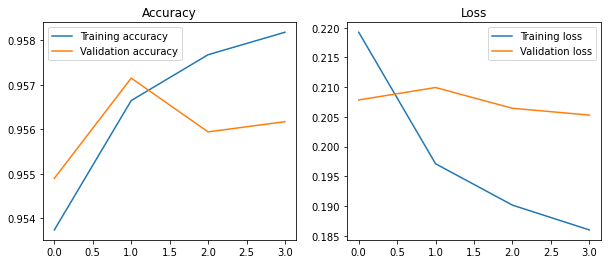

Executed


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.epoch, history.history['dice_coefficient'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_dice_coefficient'], label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()
print("Executed")

# Model Performance Check

Input Image

<Figure size 864x576 with 0 Axes>

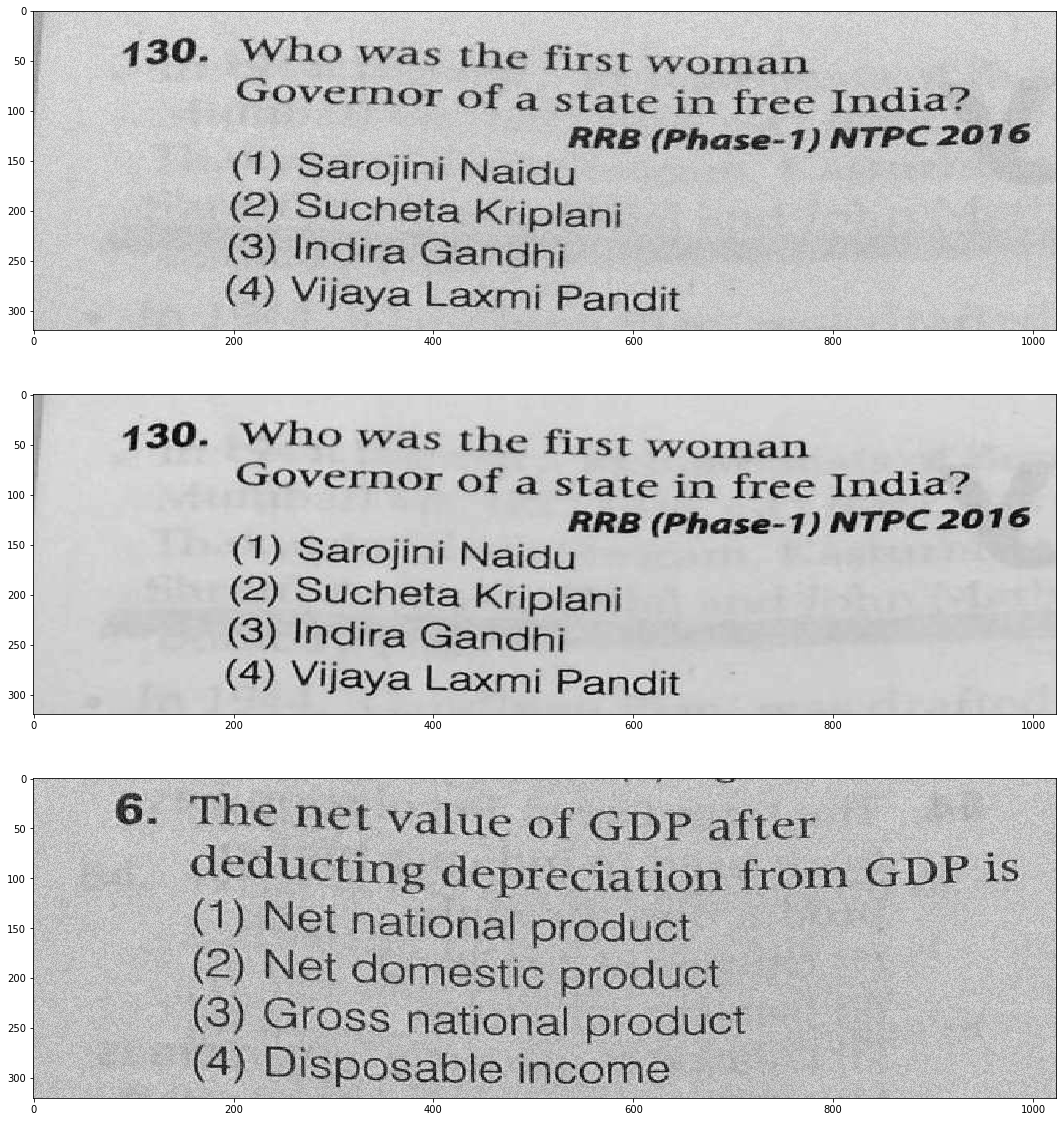

In [ ]:
v1 = np.array(test_img[0])
v2 = np.array(test_img[1])
v3 = np.array(test_img[2])

tmp1 = np.expand_dims(v1,axis=0)
tmp2 = np.expand_dims(v2,axis=0)
tmp3 = np.expand_dims(v3,axis=0)


res1 = modelUnet.predict(tmp1)
res2 = modelUnet.predict(tmp2)
res3 = modelUnet.predict(tmp3)


plt.figure(figsize=(12,8))
plt.rcParams['figure.figsize'] = [20, 20]
f, ax = plt.subplots(3,1)
ax[0].imshow(v1[:,:,0],cmap="gray")
ax[1].imshow(v2[:,:,0],cmap="gray")
ax[2].imshow(v3[:,:,0],cmap="gray")

Ground Truth

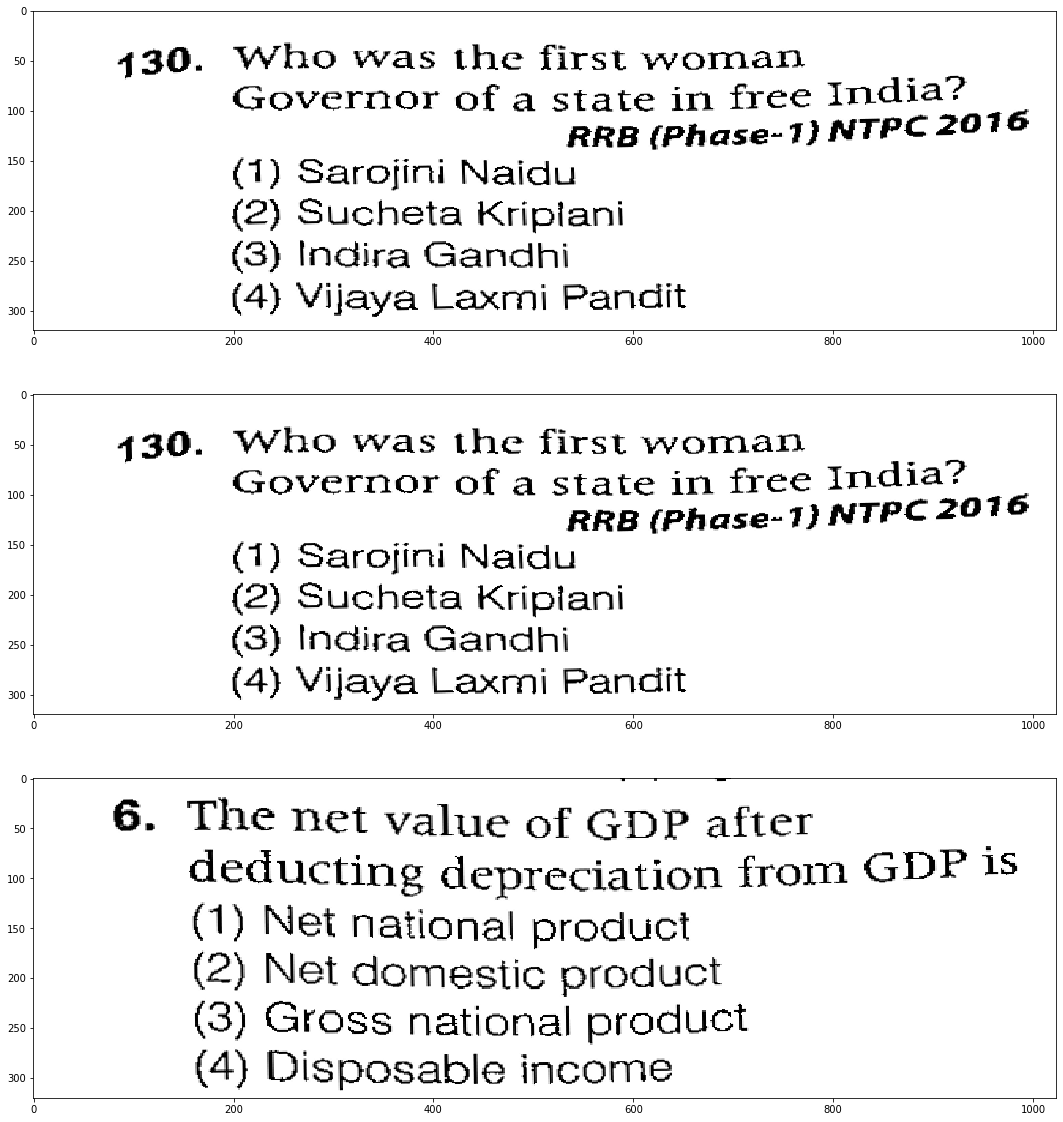

In [ ]:
f, ax = plt.subplots(3,1)
plt.rcParams['figure.figsize'] = [20, 20]
ax[0].imshow(test_lab[0][:,:,0],cmap="gray")
ax[1].imshow(test_lab[1][:,:,0],cmap="gray")
ax[2].imshow(test_lab[2][:,:,0],cmap="gray")

Model Output

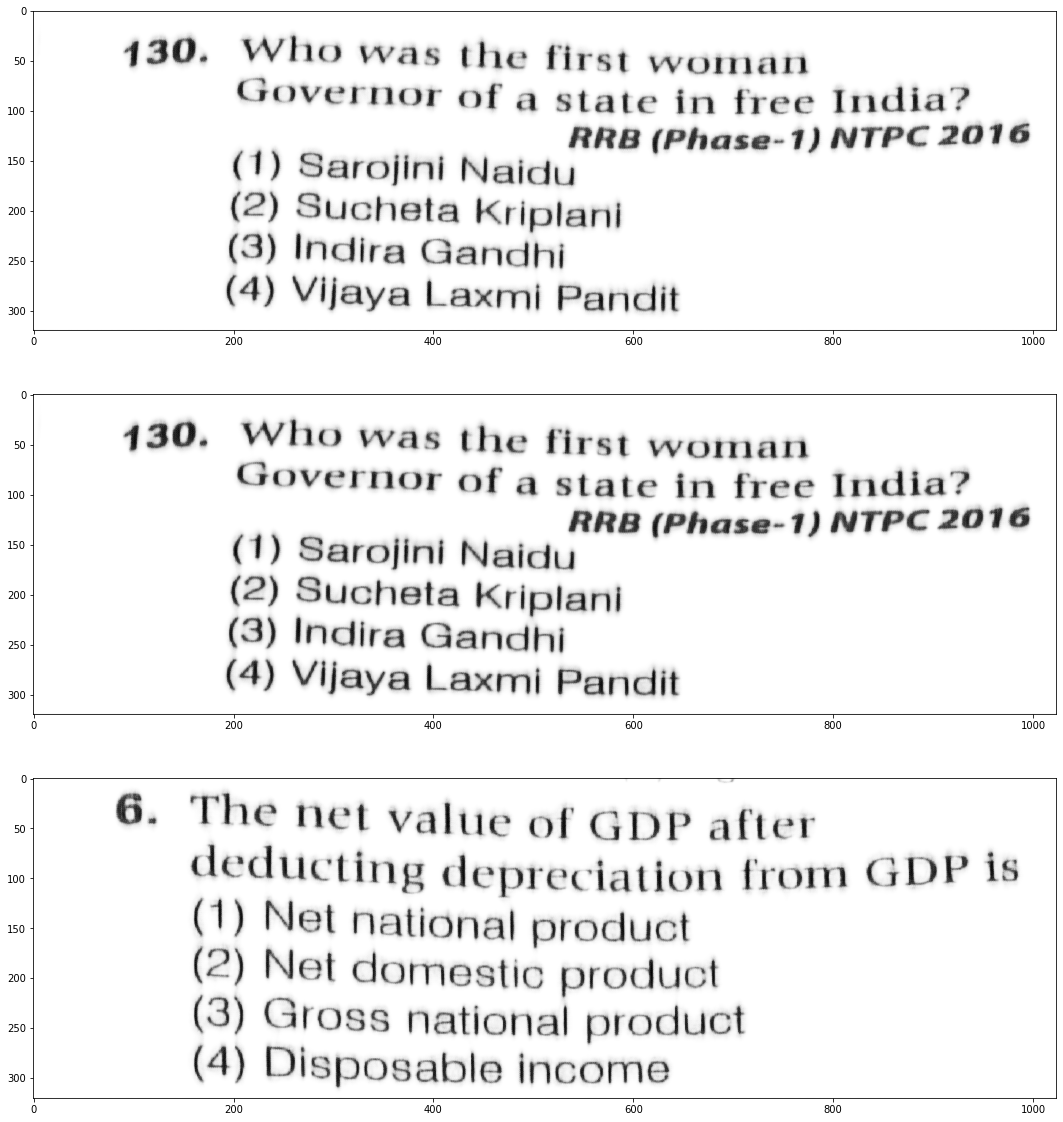

In [ ]:
f, ax = plt.subplots(3,1)
plt.rcParams['figure.figsize'] = [20, 20]
ax[0].imshow(res1[0,:,:,0],cmap="gray")
ax[1].imshow(res2[0,:,:,0],cmap="gray")
ax[2].imshow(res3[0,:,:,0],cmap="gray")

# Downloading the best validation accuracy model



In [ ]:
! ls 

 drive
 largerDataset
 largerDataset.zip
 __MACOSX
 noisy_test_input
 noisy_test_input.zip
 noisy_test_label
 noisy_test_label.zip
 noisy_train_input
 noisy_train_input.zip
 noisy_train_label
 noisy_train_label.zip
 sample_data
'UnetBinarize(320x1024)(leaky_relu)(he_normal)(TransposeConvolutions)(dice_coefficient).h5'


In [ ]:
from google.colab import files
files.download('UnetBinarize(320x1024)(leaky_relu)(he_normal)(TransposeConvolutions)(dice_coefficient).h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! ls -la

total 490180
drwxr-xr-x 1 root root      4096 Oct 12 10:09  .
drwxr-xr-x 1 root root      4096 Oct 12 09:32  ..
drwxr-xr-x 1 root root      4096 Oct  5 16:31  .config
drwx------ 5 root root      4096 Oct 12 09:33  drive
drwxr-xr-x 7 root root      4096 Oct 11 03:59  largerDataset
-rw------- 1 root root 377651737 Oct 12 09:33  largerDataset.zip
drwxr-xr-x 3 root root      4096 Oct 12 09:33  __MACOSX
drwxr-xr-x 1 root root      4096 Oct  5 16:31  sample_data
-rw-r--r-- 1 root root 124255048 Oct 12 10:33 'UnetBinarize(320x1024)(leaky_relu)(he_normal)(TransposeConvolutions).h5'


# Storing seen test image set

In [ ]:
! rm -rf noisy_test_model_output

In [ ]:
! mkdir noisy_test_model_output

In [ ]:
# validation
ctr = 0
for (i,j) in zip(test_img,test_lab):
  tmp = np.array(i)
  t = np.expand_dims(tmp,axis=0)
  res = modelUnet.predict(t)

  dpi_im = Image.fromarray(np.uint8(res[0,:,:,0]*255))
  dpi_im.save("/content/noisy_test_model_output/"+str(ctr)+".png",dpi=(300,300))  
  
  ctr+=1

In [ ]:
! zip -r ./noisy_test_model_output.zip "/content/noisy_test_model_output/" 

  adding: content/noisy_test_model_output/ (stored 0%)
  adding: content/noisy_test_model_output/29.png (deflated 0%)
  adding: content/noisy_test_model_output/9.png (deflated 0%)
  adding: content/noisy_test_model_output/14.png (deflated 0%)
  adding: content/noisy_test_model_output/5.png (deflated 0%)
  adding: content/noisy_test_model_output/15.png (deflated 0%)
  adding: content/noisy_test_model_output/22.png (deflated 0%)
  adding: content/noisy_test_model_output/27.png (deflated 0%)
  adding: content/noisy_test_model_output/24.png (deflated 0%)
  adding: content/noisy_test_model_output/18.png (deflated 0%)
  adding: content/noisy_test_model_output/26.png (deflated 0%)
  adding: content/noisy_test_model_output/7.png (deflated 0%)
  adding: content/noisy_test_model_output/11.png (deflated 0%)
  adding: content/noisy_test_model_output/19.png (deflated 0%)
  adding: content/noisy_test_model_output/17.png (deflated 0%)
  adding: content/noisy_test_model_output/30.png (deflated 0%)
  a

## Random Unseen Images are also checked :

In [ ]:
# file uploaded from local system & not drive
! unzip NEWTEST.zip

Archive:  NEWTEST.zip
   creating: NEWTEST/
  inflating: NEWTEST/2934.png        
  inflating: NEWTEST/2933.png        
  inflating: NEWTEST/2927.png        
  inflating: NEWTEST/2926.png        
  inflating: NEWTEST/2932.png        
  inflating: NEWTEST/2930.png        
  inflating: NEWTEST/2931.png        
  inflating: NEWTEST/2925.png        
  inflating: NEWTEST/2928.png        
  inflating: NEWTEST/2929.png        


In [ ]:
! ls ./largerDataset/final_test_images

3946.png  3953.png  3960.png  3967.png	3974.png  3981.png  3988.png  3995.png
3947.png  3954.png  3961.png  3968.png	3975.png  3982.png  3989.png  3996.png
3948.png  3955.png  3962.png  3969.png	3976.png  3983.png  3990.png  3997.png
3949.png  3956.png  3963.png  3970.png	3977.png  3984.png  3991.png  3998.png
3950.png  3957.png  3964.png  3971.png	3978.png  3985.png  3992.png  3999.png
3951.png  3958.png  3965.png  3972.png	3979.png  3986.png  3993.png
3952.png  3959.png  3966.png  3973.png	3980.png  3987.png  3994.png


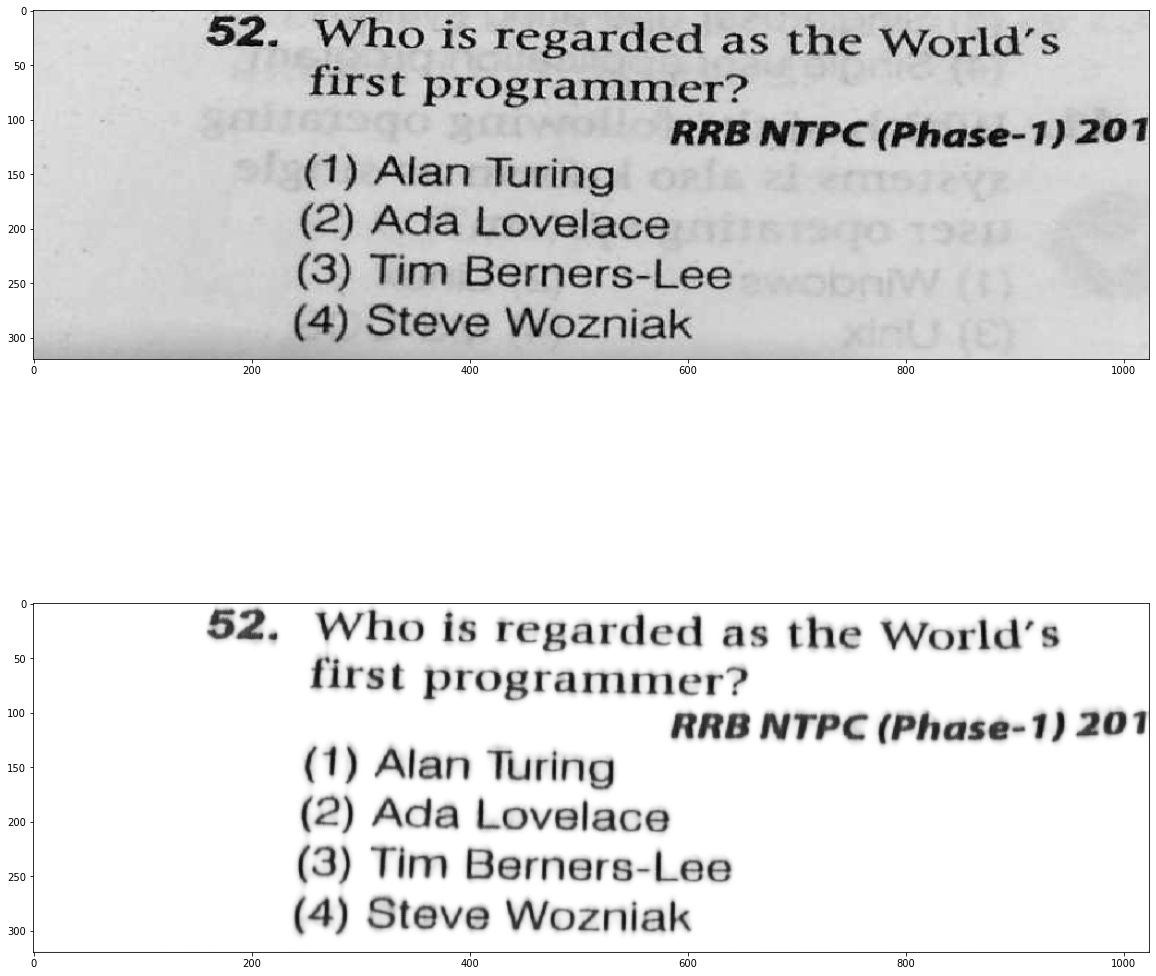

In [ ]:
image = load_img("./largerDataset/final_test_images/3985.png", color_mode="grayscale", target_size = (320,1024))
image = img_to_array(image)
image /=255
t = np.expand_dims(image,axis=0)
result = modelUnet.predict(t)


f, ax = plt.subplots(2,1)

plt.rcParams['figure.figsize'] = [20, 20]
# Input
ax[0].imshow(t[0,:,:,0],cmap="gray")

# Model output
ax[1].imshow(result[0,:,:,0],cmap="gray")

In [ ]:
! rm -rf final_test_images_model_output/

In [ ]:
! mkdir final_test_images_model_output/

In [ ]:
path = "./largerDataset/final_test_images"
for i in os.listdir(path):
  image = load_img(path+"/"+i,   color_mode="grayscale", target_size = (320,1024))
  image = img_to_array(image)
  image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
  image/= 255
  tmp = np.array(image)
  t = np.expand_dims(tmp,axis=0)
  res = modelUnet.predict(t)

  dpi_im = Image.fromarray(np.uint8(res[0,:,:,0]*255))
  dpi_im.save("/content/final_test_images_model_output/"+i,dpi=(300,300))  


In [ ]:
! zip -r ./final_test_images_model_input.zip "./largerDataset/final_test_images" 
! zip -r ./final_test_images_model_output.zip "/content/final_test_images_model_output/"
print("Executed")

# Model weights load for further testing

In [ ]:
# upload the .h5 file attached with this zip folder
from google.colab import files
files.upload()

In [ ]:
weightsFilename = ""

In [ ]:
new_model = tf.keras.models.load_model(weightsFilename)
new_model.summary()